In [10]:
import os
import zipfile
from google.colab import drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import zipfile
from google.colab import drive

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'

# Specify the path where you want to extract the train and validation files
extracted_data_path = '/content/drive/MyDrive/Colab Notebooks/face_recog_image2'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_data_path, exist_ok=True)

# Extract the train and validation files
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if 'train' in file or 'validation' in file:
            zip_ref.extract(file, path=extracted_data_path)

# List the extracted files
extracted_files = os.listdir(extracted_data_path)
print("Extracted files:")
for file in extracted_files:
    print(file)

Extracted files:
images


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Dropout,MaxPool2D,Flatten,BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

In [3]:
Train_dir='/content/drive/MyDrive/Colab Notebooks/face_recog_image2/images/train'
Test_dir='/content/drive/MyDrive/Colab Notebooks/face_recog_image2/images/validation'

In [4]:
import os

def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                image_path = os.path.join(label_dir, filename)
                image_paths.append(image_path)
                labels.append(label)
            print(label, "Completed")

    return image_paths, labels

Train_dir = '/content/drive/MyDrive/Colab Notebooks/face_recog_image2/images/train'
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(Train_dir)

train = train.sample(frac=1).reset_index(drop=True)
train.head()

happy Completed
fear Completed
angry Completed
disgust Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,/content/drive/MyDrive/Colab Notebooks/face_re...,happy
1,/content/drive/MyDrive/Colab Notebooks/face_re...,fear
2,/content/drive/MyDrive/Colab Notebooks/face_re...,neutral
3,/content/drive/MyDrive/Colab Notebooks/face_re...,neutral
4,/content/drive/MyDrive/Colab Notebooks/face_re...,happy


In [5]:
Test_dir='/content/drive/MyDrive/Colab Notebooks/face_recog_image2/images/validation'
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(Test_dir)

test = test.sample(frac=1).reset_index(drop=True)
test.head()

happy Completed
sad Completed
angry Completed
disgust Completed
fear Completed
neutral Completed
surprise Completed


,image,label
0,/content/drive/MyDrive/Colab Notebooks/face_re...,sad
1,/content/drive/MyDrive/Colab Notebooks/face_re...,sad
2,/content/drive/MyDrive/Colab Notebooks/face_re...,neutral
3,/content/drive/MyDrive/Colab Notebooks/face_re...,sad
4,/content/drive/MyDrive/Colab Notebooks/face_re...,neutral


In [6]:
train.shape

(28821, 2)

In [7]:
test.shape

(6286, 2)

In [8]:
# EDA

In [9]:
train.label.value_counts()

happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: label, dtype: int64

In [10]:
test.label.value_counts()

happy       1825
neutral     1216
sad         1139
fear        1018
angry        960
disgust      111
surprise      17
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

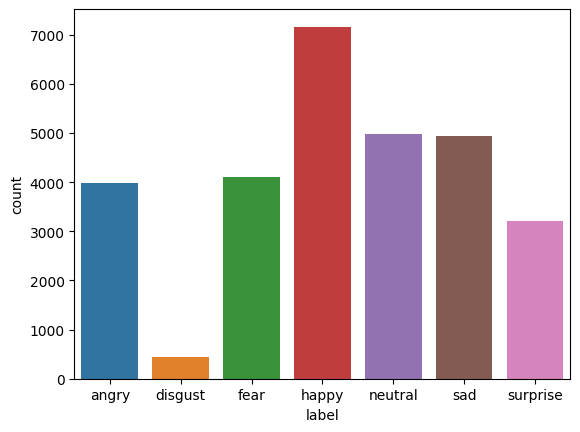

In [11]:
import seaborn as sns

# Convert the 'label' column to categorical data type
train['label'] = train['label'].astype('category')

# Plot the countplot
sns.countplot(data=train, x='label')

<Axes: xlabel='label', ylabel='count'>

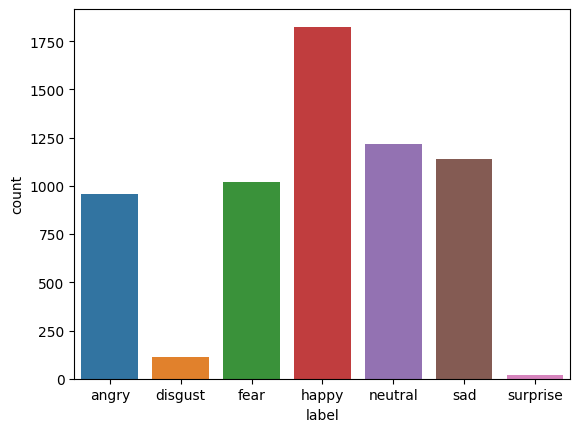

In [12]:
import seaborn as sns

# Convert the 'label' column to categorical data type
test['label'] = test['label'].astype('category')

# Plot the countplot
sns.countplot(data=test, x='label')

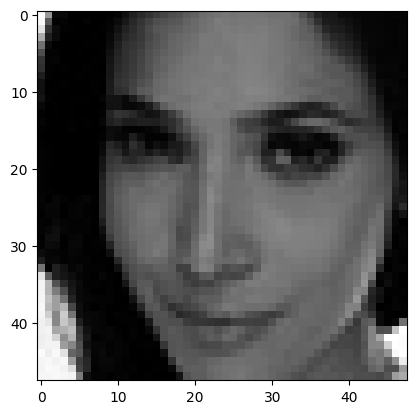

In [13]:
from PIL import Image
img=Image.open(train['image'][0])
plt.imshow(img,cmap='gray')

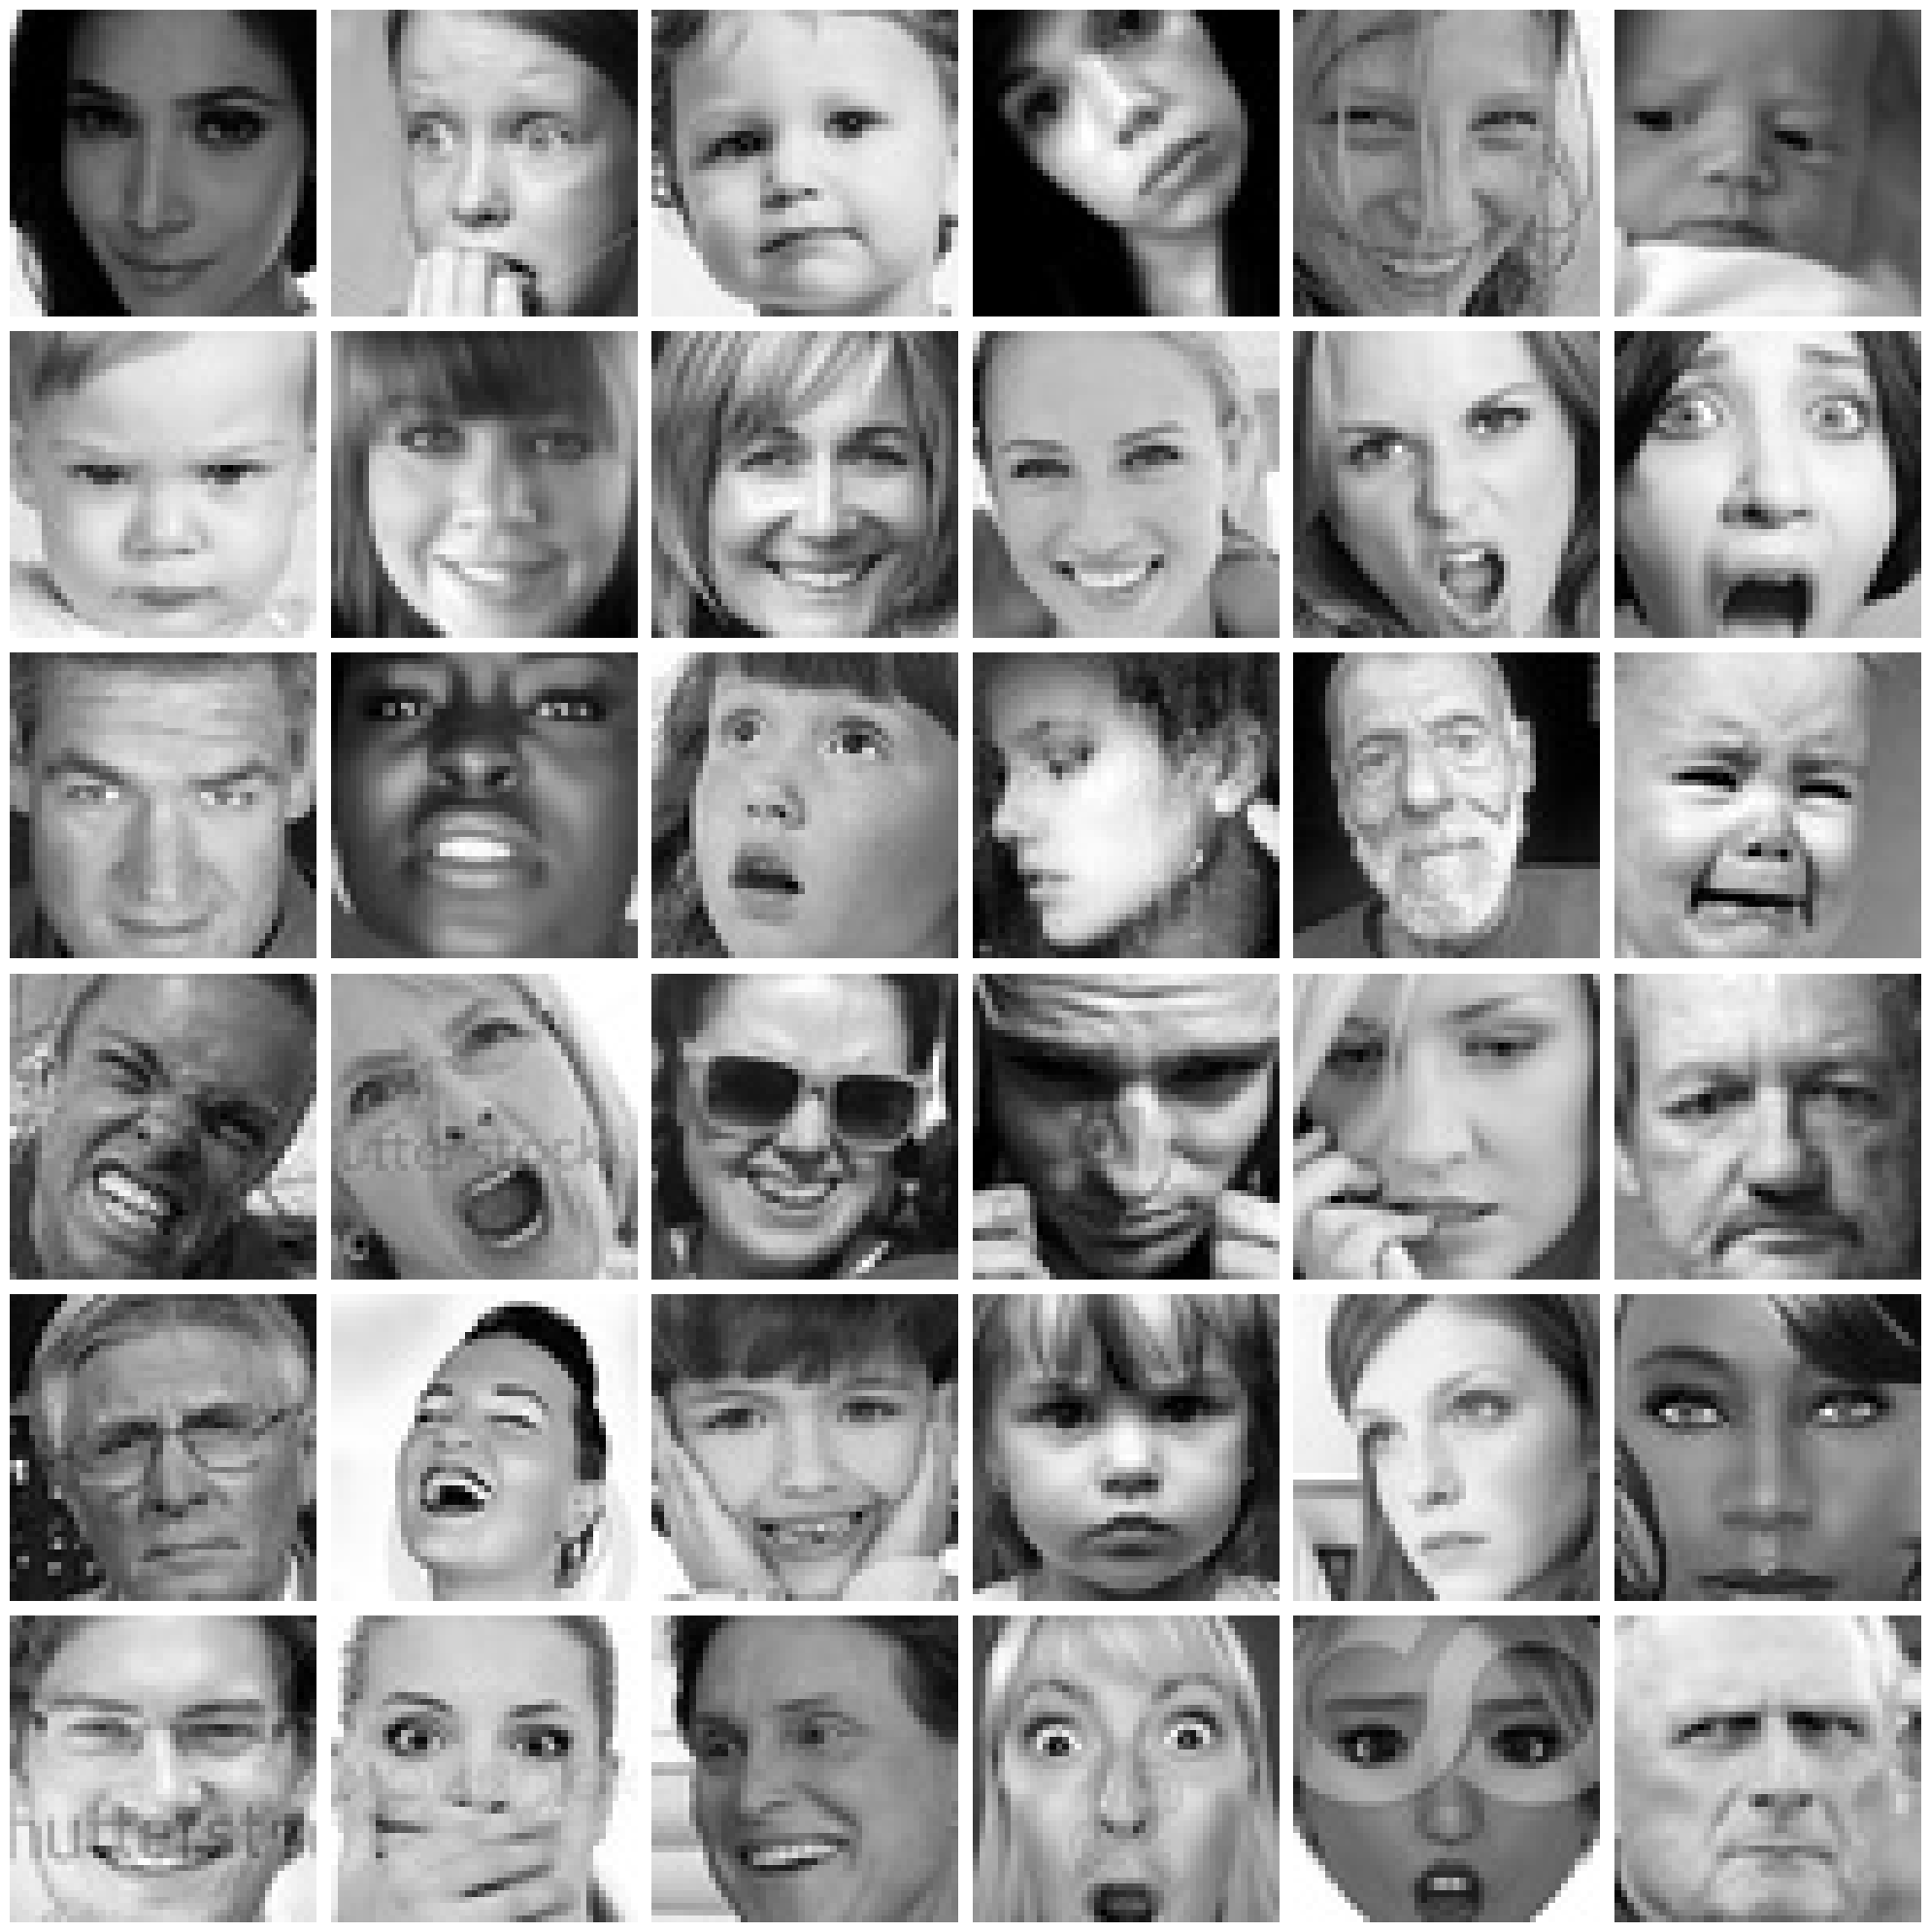

In [14]:
fig, ax = plt.subplots(6, 6, figsize=(20,20))
k = 0

for i in range(6):
    for j in range(6):
        img_path = train['image'][k]
        img = Image.open(img_path)
        ax[i][j].imshow(img, cmap='gray')
        ax[i][j].axis('off')
        k += 1

plt.tight_layout()
plt.show()


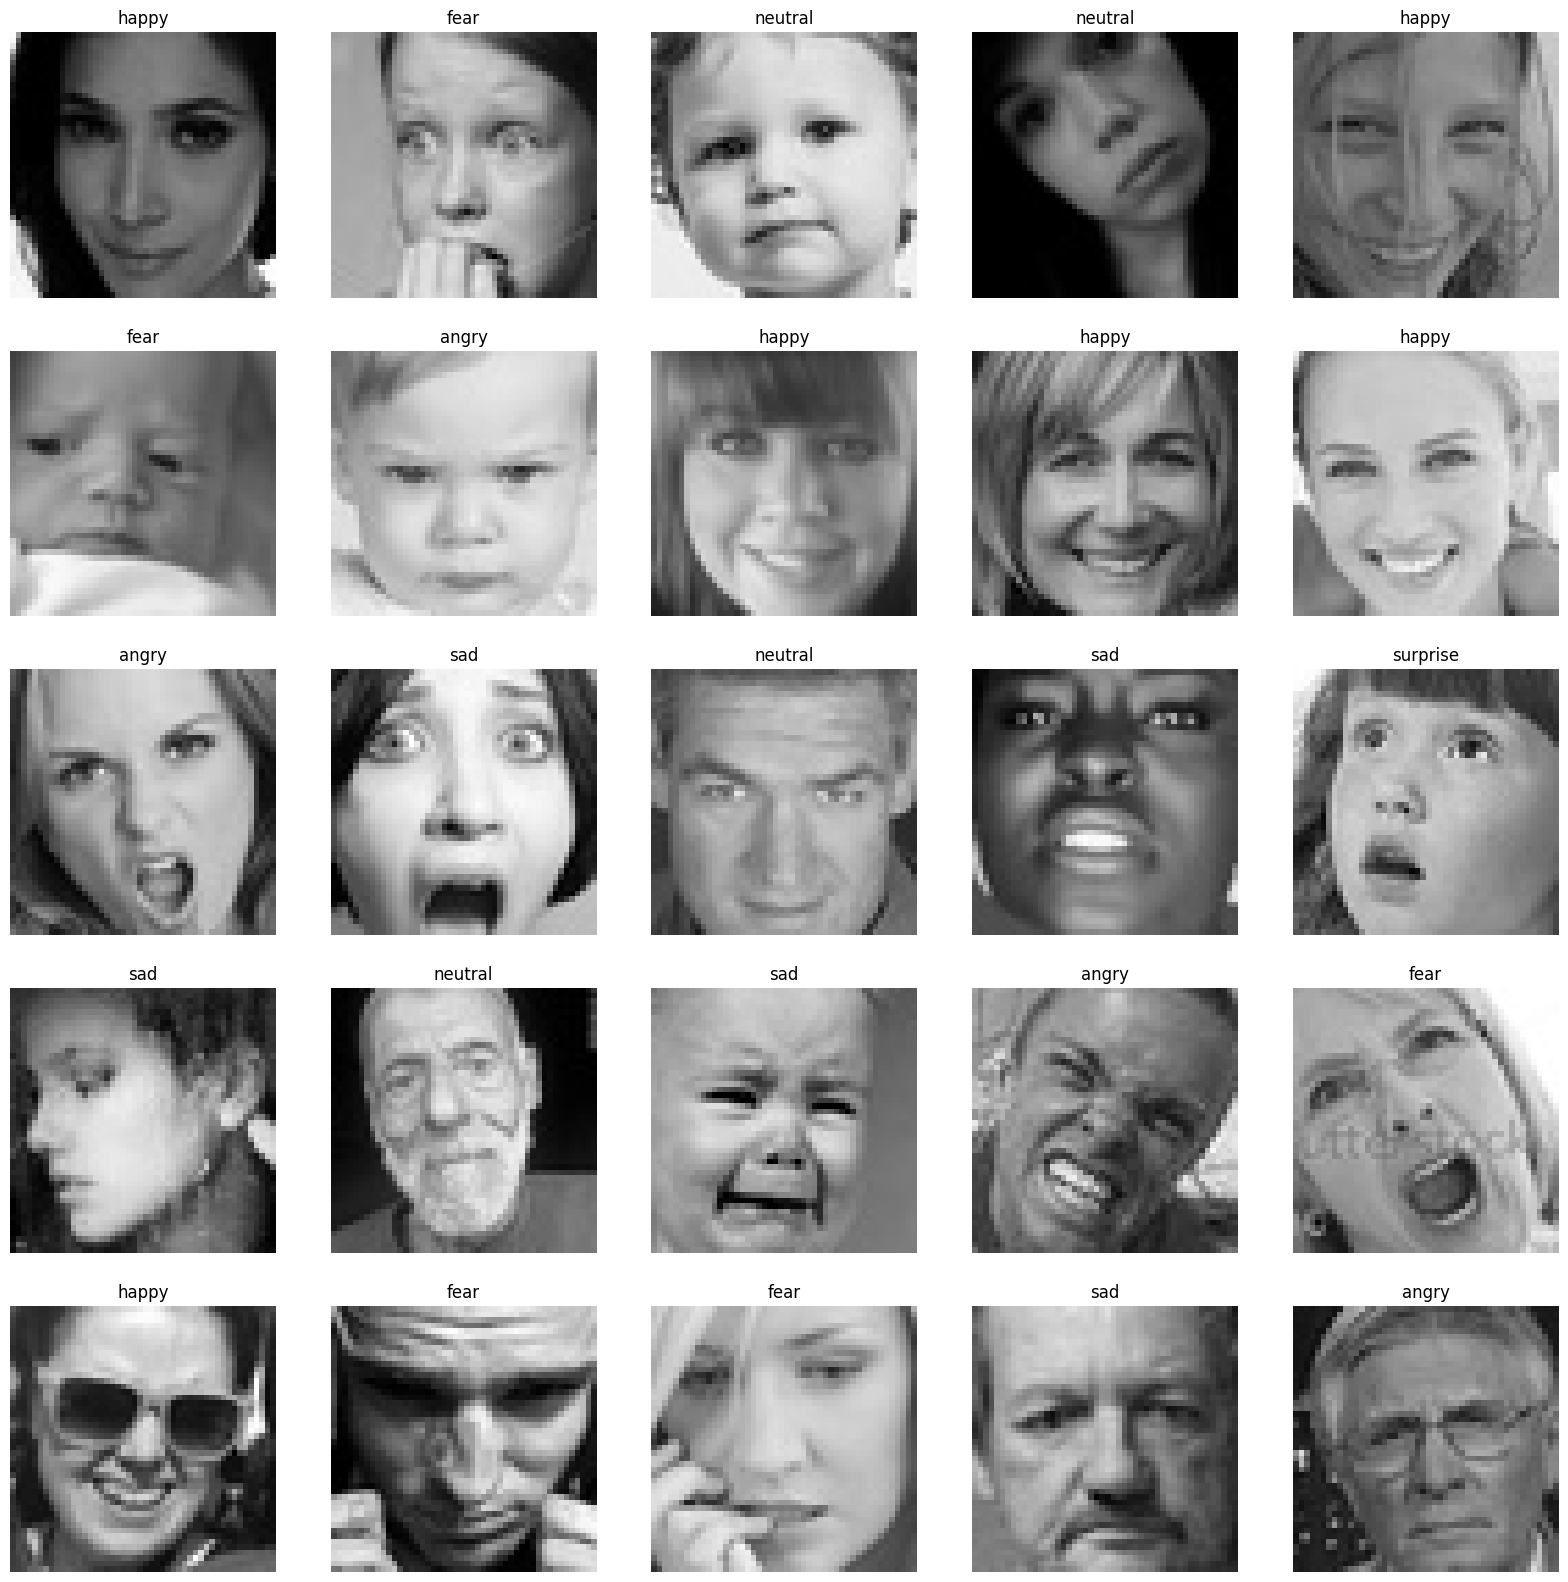

In [15]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [16]:
def extract_features(images):
  features=[]
  for image in tqdm(images):
    img=load_img(image,grayscale='True')
    img=np.array(img)
    features.append(img)
  features=np.array(features)
  features=features.reshape(len(features),48,48,1)
  return features

In [17]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
test_features = extract_features(test['image'])

In [ ]:
# Normalize the features
x_train=train_features/255
x_test=test_features/255

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(train['label'])
y_test=le.transform(test['label'])

In [ ]:
y_train=to_categorical(y_train,num_classes=7)
y_test=to_categorical(y_test,num_classes=7)

In [ ]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [36]:
model=Sequential()

# Layer1
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape,padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

# Layer2
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

# Layer3
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

# Layer4
model.add(Conv2D(252,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

# Layer5
model.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Neural Network

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))

# output Layer

model.add(Dense(output_class,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics='accuracy')

In [37]:
history = model.fit(x=x_train, y=y_train, batch_size=128,epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
226/226 [==============================] - 19s 23ms/step - loss: 1.8518 - accuracy: 0.2351 - val_loss: 1.8090 - val_accuracy: 0.2583
Epoch 2/100
226/226 [==============================] - 4s 20ms/step - loss: 1.8171 - accuracy: 0.2443 - val_loss: 1.7976 - val_accuracy: 0.2583
Epoch 3/100
226/226 [==============================] - 4s 19ms/step - loss: 1.8067 - accuracy: 0.2468 - val_loss: 1.8001 - val_accuracy: 0.2583
Epoch 4/100
226/226 [==============================] - 4s 19ms/step - loss: 1.7969 - accuracy: 0.2483 - val_loss: 1.7774 - val_accuracy: 0.2583
Epoch 5/100
226/226 [==============================] - 5s 20ms/step - loss: 1.7856 - accuracy: 0.2548 - val_loss: 1.7454 - val_accuracy: 0.2910
Epoch 6/100
226/226 [==============================] - 4s 19ms/step - loss: 1.7475 - accuracy: 0.2814 - val_loss: 1.6959 - val_accuracy: 0.3115
Epoch 7/100
226/226 [==============================] - 4s 19ms/step - loss: 1.7116 - accuracy: 0.2951 - val_loss: 1.6462 - val_accuracy

In [39]:
model=Sequential()

# Layer1
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape,padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

# Layer2
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

# Layer3
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

# Layer4
model.add(Conv2D(252,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

# Layer5
model.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Neural Network

model.add(Dense(128,activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(64,activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(32,activation='tanh'))
model.add(Dropout(0.4))

# output Layer

model.add(Dense(output_class,activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics='accuracy')

In [40]:
history = model.fit(x=x_train, y=y_train, batch_size=128,epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
226/226 [==============================] - 7s 20ms/step - loss: 1.8472 - accuracy: 0.2274 - val_loss: 1.8200 - val_accuracy: 0.2583
Epoch 2/100
226/226 [==============================] - 5s 20ms/step - loss: 1.8135 - accuracy: 0.2386 - val_loss: 1.7858 - val_accuracy: 0.2583
Epoch 3/100
226/226 [==============================] - 4s 19ms/step - loss: 1.7970 - accuracy: 0.2511 - val_loss: 1.7642 - val_accuracy: 0.2801
Epoch 4/100
226/226 [==============================] - 4s 19ms/step - loss: 1.7614 - accuracy: 0.2746 - val_loss: 1.6944 - val_accuracy: 0.3095
Epoch 5/100
226/226 [==============================] - 5s 22ms/step - loss: 1.6965 - accuracy: 0.3135 - val_loss: 1.5892 - val_accuracy: 0.3733
Epoch 6/100
226/226 [==============================] - 4s 19ms/step - loss: 1.6287 - accuracy: 0.3461 - val_loss: 1.5573 - val_accuracy: 0.3840
Epoch 7/100
226/226 [==============================] - 4s 19ms/step - loss: 1.5728 - accuracy: 0.3730 - val_loss: 1.5465 - val_accuracy:

In [1]:
from keras.initializers import glorot_uniform

# Create the CNN model
model = Sequential()

# Convolution layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=glorot_uniform(seed=42), input_shape=input_shape))
for _ in range(14):
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=glorot_uniform(seed=42)))

# Pooling layers
model.add(MaxPooling2D(pool_size=(2, 2)))
for _ in range(2):
    model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layers
model.add(Dropout(0.25))
for _ in range(3):
    model.add(Dropout(0.4))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_class, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

NameError: ignored

In [ ]:
history = model.fit(x=x_train, y=y_train, batch_size=32,epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
901/901 [==============================] - 124s 13ms/step - loss: 1.9802 - accuracy: 0.1915 - val_loss: 1.8051 - val_accuracy: 0.2581
Epoch 2/100
901/901 [==============================] - 11s 12ms/step - loss: 1.8581 - accuracy: 0.2095 - val_loss: 1.8218 - val_accuracy: 0.2552
Epoch 3/100
901/901 [==============================] - 11s 12ms/step - loss: 1.8281 - accuracy: 0.2309 - val_loss: 1.8107 - val_accuracy: 0.2485
Epoch 4/100
901/901 [==============================] - 11s 13ms/step - loss: 1.8136 - accuracy: 0.2396 - val_loss: 1.7977 - val_accuracy: 0.2577
Epoch 5/100
901/901 [==============================] - 11s 12ms/step - loss: 1.8038 - accuracy: 0.2483 - val_loss: 1.7908 - val_accuracy: 0.2661
Epoch 6/100
901/901 [==============================] - 11s 12ms/step - loss: 1.7978 - accuracy: 0.2498 - val_loss: 1.7790 - val_accuracy: 0.2720
Epoch 7/100
901/901 [==============================] - 11s 12ms/step - loss: 1.7920 - accuracy: 0.2543 - val_loss: 1.7734 - val_a